In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings

warnings.filterwarnings("ignore")
import logging

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow import expand_dims
from tensorflow.keras.losses import MeanAbsolutePercentageError
import tensorflow

from datetime import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot

/home/amirel/.pyenv/versions/3.8.12/envs/time_series/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-09-13 09:41:21.659549: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-13 09:41:22.180802: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-13 09:41:22.345900: W tensorflow/stream_executor/p

# LSTM 2017-2018


In [2]:
df = pd.read_csv('../../AltInt/Inflation_prediction/raw_data/final_df.csv', index_col=0)


In [3]:
df.index = pd.to_datetime(df.index)
df

,Brent_Crude_GBP,WTI_Crude_GBP,GBP Curncy,GBPEUR Curncy,UKX Index,SPX Index,SX5E Index,Natural_Gas,CPI,RPI,GBP_IRS_2y,GBP_IRS_10y,Nationwide_HPI,RPI YOY
Date,,,,,,,,,,,,,,
2009-01-01,30.903838,33.424333,1.479027,1.099905,4308.390000,596.071497,2135.982324,12.472805,84.9,210.1,2.122545,3.757500,300.2,0.142993
2009-02-01,29.393166,33.617553,1.492643,1.120824,4232.114762,570.410394,2020.716905,9.467866,85.6,211.4,2.129905,3.798333,294.7,0.000000
2009-03-01,31.733352,36.826152,1.494241,1.097877,4107.840909,566.393975,2029.160819,8.064295,85.8,211.3,2.142045,3.872500,301.1,-0.377181
2009-04-01,33.990786,36.012519,1.511936,1.125327,4259.890500,588.042125,2119.383029,7.762397,86.0,211.5,2.143250,3.935500,302.9,-1.168224
2009-05-01,37.524515,38.801542,1.561252,1.131686,4434.719500,582.718727,2164.120107,7.757394,86.4,212.8,2.031900,3.917500,307.2,-1.069270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-01,89.748267,85.128666,1.247484,1.178074,7472.767778,3274.256696,3179.554466,81.073170,120.8,337.1,2.538121,2.240542,538.4,11.659490
2022-06-01,95.251442,87.836565,1.233611,1.167758,7238.188421,3172.340166,3058.969505,96.746393,121.8,340.0,2.933563,2.626558,541.8,11.842105
2022-07-01,85.363871,80.415504,1.231479,1.184589,7303.865263,3298.689210,3082.959231,128.688654,122.5,343.2,2.700779,2.302258,541.0,12.340426


In [4]:
#rpi_lag = pd.read_csv('RPI_lagged.csv')


In [5]:
#rpi_lag

In [6]:
# rpi_lag = rpi_lag.rename({'Date CO1 Comdty': 'Date'}, axis=1)
# rpi_lag = rpi_lag.set_index('Date')


In [7]:
#rpi_lag.index = pd.to_datetime(rpi_lag.index)

In [8]:
#rpi_lag

In [9]:
#new_df = df.join(rpi_lag)

In [10]:
#new_df

In [11]:
# X = new_df.drop(columns = ['RPI', 'CPI', 'RPI YOY'])
# y = new_df['RPI']

X = df.drop(columns = ['RPI', 'CPI', 'RPI YOY'])
y = df['RPI']

In [12]:
X[72:96]

,Brent_Crude_GBP,WTI_Crude_GBP,GBP Curncy,GBPEUR Curncy,UKX Index,SPX Index,SX5E Index,Natural_Gas,GBP_IRS_2y,GBP_IRS_10y,Nationwide_HPI
Date,,,,,,,,,,,
2015-01-01,32.818125,31.737054,1.516177,1.336264,6641.765238,1339.503656,2495.664852,13.099203,0.858274,1.684729,375.9
2015-02-01,38.343255,32.759207,1.533386,1.362371,6746.840476,1356.232800,2536.801725,13.938965,0.952887,1.856450,375.0
2015-03-01,37.866261,31.635113,1.503677,1.377568,6791.140000,1380.431518,2615.694574,13.821672,0.947216,1.783045,377.9
2015-04-01,40.409377,35.572047,1.512909,1.386036,6886.650952,1381.813784,2620.084413,13.690119,0.923663,1.811432,385.1
2015-05-01,42.505052,36.186768,1.543548,1.384014,6864.994500,1360.216539,2568.111738,13.123988,1.009908,1.971630,389.3
2015-06-01,41.067582,35.885473,1.552386,1.385524,6687.803500,1340.919813,2507.691659,13.023503,1.061182,2.089545,389.1
2015-07-01,36.726002,31.989864,1.545617,1.402913,6625.526087,1353.218881,2518.626151,13.169073,1.119989,2.051104,390.2
2015-08-01,31.196110,29.152671,1.545248,1.376957,6402.255000,1311.027051,2434.955959,12.478583,1.085050,1.958367,389.6
2015-09-01,31.774855,30.721787,1.527609,1.364657,6280.524348,1302.101893,2375.712634,12.595702,1.004023,1.908904,390.2


In [13]:
X_train, y_train = X[:72], y[:72]
X_val, y_val = X[72:96], y[72:96]
X_test, y_test = X[96:108], y[96:108]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((72, 11), (72,), (24, 11), (24,), (12, 11), (12,))

In [14]:
y_train_x = expand_dims(y_train, -1)
y_train_x = expand_dims(y_train_x, -1)

y_train_x.shape

2022-09-13 09:41:34.221537: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-13 09:41:34.222236: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-13 09:41:34.222272: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-S0KUROGM): /proc/driver/nvidia/version does not exist
2022-09-13 09:41:34.226836: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorShape([72, 1, 1])

In [15]:
y_val_x = expand_dims(y_val, -1)
y_val_x = expand_dims(y_val_x, -1)

In [16]:
y_val_x.shape

TensorShape([24, 1, 1])

In [17]:
X_test_x = expand_dims(X_test, -2)

In [18]:
X_test_x.shape

TensorShape([12, 1, 11])

In [19]:
X_train_x = expand_dims(X_train, -2)
X_train_x.shape

TensorShape([72, 1, 11])

In [20]:
X_val_x = expand_dims(X_val, -2)
X_val_x.shape

TensorShape([24, 1, 11])

In [21]:
lr_scheduler = ExponentialDecay(initial_learning_rate=0.001, decay_steps= 10_000, decay_rate=0.7)
adam = Adam(learning_rate=lr_scheduler)
es = EarlyStopping(patience=50, restore_best_weights=True)

In [22]:
normalizer = Normalization()
normalizer.adapt(X_train_x)

model1 = Sequential()
model1.add(normalizer)

model1.add(LSTM(units = 100, activation='tanh', return_sequences = True))
model1.add(LSTM(units = 50 , activation='tanh', return_sequences = False))

model1.add(Flatten())

model1.add(Dense(100,activation =  'relu'))
model1.add(Dense(50,activation =  'relu'))
model1.add(Dense(25,activation =  'relu'))

model1.add(Dense(1, activation = 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, None, 11)         23        
 n)                                                              
                                                                 
 lstm (LSTM)                 (None, None, 100)         44800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 flatten (Flatten)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 100)               5100      
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                        

In [23]:
mape = MeanAbsolutePercentageError()

In [24]:
model1.compile(loss= mape, optimizer= adam, metrics=['mape'])

In [25]:
model1.fit(X_train_x, y_train,batch_size = 32, validation_data=(X_val_x, y_val), epochs=10000, callbacks = (es))

Epoch 1/10000
3/3 [==============================] - 3s 312ms/step - loss: 99.9993 - mape: 99.9993 - val_loss: 99.9948 - val_mape: 99.9948
Epoch 2/10000
3/3 [==============================] - 0s 26ms/step - loss: 99.9891 - mape: 99.9891 - val_loss: 99.9853 - val_mape: 99.9853
Epoch 3/10000
3/3 [==============================] - 0s 24ms/step - loss: 99.9771 - mape: 99.9771 - val_loss: 99.9735 - val_mape: 99.9735
Epoch 4/10000
3/3 [==============================] - 0s 25ms/step - loss: 99.9618 - mape: 99.9618 - val_loss: 99.9586 - val_mape: 99.9586
Epoch 5/10000
3/3 [==============================] - 0s 25ms/step - loss: 99.9421 - mape: 99.9421 - val_loss: 99.9399 - val_mape: 99.9399
Epoch 6/10000
3/3 [==============================] - 0s 26ms/step - loss: 99.9168 - mape: 99.9168 - val_loss: 99.9166 - val_mape: 99.9166
Epoch 7/10000
3/3 [==============================] - 0s 25ms/step - loss: 99.8848 - mape: 99.8848 - val_loss: 99.8869 - val_mape: 99.8869
Epoch 8/10000
3/3 [==============

3/3 [==============================] - 0s 23ms/step - loss: 3.7327 - mape: 3.7327 - val_loss: 73.4658 - val_mape: 73.4658
Epoch 61/10000
3/3 [==============================] - 0s 22ms/step - loss: 3.6422 - mape: 3.6422 - val_loss: 71.2413 - val_mape: 71.2413
Epoch 62/10000
3/3 [==============================] - 0s 21ms/step - loss: 3.4395 - mape: 3.4395 - val_loss: 69.1542 - val_mape: 69.1542
Epoch 63/10000
3/3 [==============================] - 0s 22ms/step - loss: 3.4709 - mape: 3.4709 - val_loss: 66.7279 - val_mape: 66.7279
Epoch 64/10000
3/3 [==============================] - 0s 21ms/step - loss: 3.2882 - mape: 3.2882 - val_loss: 65.0346 - val_mape: 65.0346
Epoch 65/10000
3/3 [==============================] - 0s 19ms/step - loss: 3.3254 - mape: 3.3254 - val_loss: 63.6102 - val_mape: 63.6102
Epoch 66/10000
3/3 [==============================] - 0s 20ms/step - loss: 3.1932 - mape: 3.1932 - val_loss: 62.5877 - val_mape: 62.5877
Epoch 67/10000
3/3 [==============================] - 0s

In [26]:
model1.predict(X_test_x)

1/1 [==============================] - 1s 625ms/step


array([[231.6092 ],
       [240.51495],
       [211.37852],
       [231.9988 ],
       [226.3572 ],
       [211.47878],
       [212.16666],
       [211.12718],
       [229.58894],
       [232.91685],
       [251.76726],
       [266.5486 ]], dtype=float32)

In [27]:
test_predictions = list(model1.predict(X_test_x))
test_results = pd.DataFrame(columns = ['test_predictions', 'test_actual'])

#train_predictions

test_results['date'] = list(y_test.index)
test_results['test_predictions'] = [x[0] for x in test_predictions]
test_results['test_actual'] = list(y_test)


1/1 [==============================] - 0s 27ms/step


In [28]:
test_results

,test_predictions,test_actual,date
0,231.609207,265.5,2017-01-01
1,240.514954,268.4,2017-02-01
2,211.378525,269.3,2017-03-01
3,231.998795,270.6,2017-04-01
4,226.357193,271.7,2017-05-01
5,211.478775,272.3,2017-06-01
6,212.166656,272.9,2017-07-01
7,211.127182,274.7,2017-08-01
8,229.588943,275.1,2017-09-01
9,232.916855,275.3,2017-10-01


In [29]:
test_results.set_index('date', inplace=True)

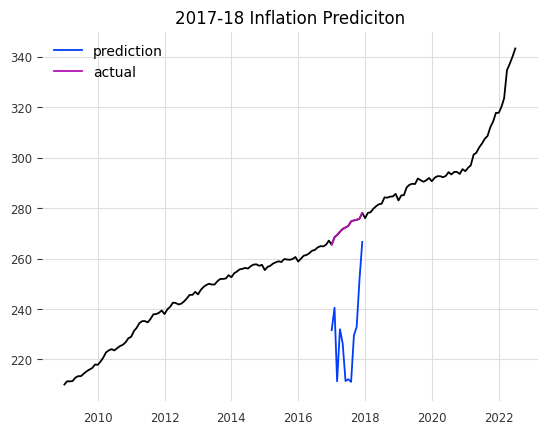

In [30]:
import matplotlib.pyplot as plt

plt.plot(y)
plt.plot(test_results['test_predictions'], label='prediction')
plt.plot(test_results['test_actual'], label='actual')
plt.title('2017-18 Inflation Prediciton')
plt.legend()
#plt.savefig('LSTM_new')



# LSTM 2018-2019

In [31]:
X_train1, y_train1 = X[:84], y[:84]
X_val1, y_val1 = X[84:108], y[84:108]
X_test1, y_test1 = X[108:120], y[108:120]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((84, 11), (84,), (24, 11), (24,), (12, 11), (12,))

In [32]:
y_train1_x = expand_dims(y_train1, -1)
y_train1_x = expand_dims(y_train1_x, -1)

y_train1_x.shape

TensorShape([84, 1, 1])

In [33]:
y_val1_x = expand_dims(y_val1, -1)
y_val1_x = expand_dims(y_val1_x, -1)

In [34]:
X_test1_x = expand_dims(X_test1, -2)

In [35]:
X_train1_x = expand_dims(X_train1, -2)
X_train1_x.shape

TensorShape([84, 1, 11])

In [36]:
X_val1_x = expand_dims(X_val1, -2)
X_val1_x.shape

TensorShape([24, 1, 11])

In [37]:
lr_scheduler = ExponentialDecay(initial_learning_rate=0.001, decay_steps= 10_000, decay_rate=0.7)
adam = Adam(learning_rate=lr_scheduler)
es = EarlyStopping(patience=50, restore_best_weights=True)

In [38]:
normalizer = Normalization()
normalizer.adapt(X_train1_x)

model2 = Sequential()
model2.add(normalizer)

model2.add(LSTM(units = 100, activation='tanh', return_sequences = True))
model2.add(LSTM(units = 50 , activation='tanh', return_sequences = False))

model2.add(Flatten())

model2.add(Dense(100,activation =  'relu'))
model2.add(Dense(50,activation =  'relu'))
model2.add(Dense(25,activation =  'relu'))

model2.add(Dense(1, activation = 'linear'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, None, 11)         23        
 ion)                                                            
                                                                 
 lstm_2 (LSTM)               (None, None, 100)         44800     
                                                                 
 lstm_3 (LSTM)               (None, 50)                30200     
                                                                 
 flatten_1 (Flatten)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 100)               5100      
                                                                 
 dense_5 (Dense)             (None, 50)                5050      
                                                      

In [39]:
model2.compile(loss= mape, optimizer= adam, metrics=['mape'])

In [40]:
model2.fit(X_train1_x, y_train1,batch_size = 32, validation_data=(X_val1_x, y_val1), epochs=10000, callbacks = (es))

Epoch 1/10000
3/3 [==============================] - 3s 276ms/step - loss: 99.9934 - mape: 99.9934 - val_loss: 99.9796 - val_mape: 99.9796
Epoch 2/10000
3/3 [==============================] - 0s 27ms/step - loss: 99.9740 - mape: 99.9740 - val_loss: 99.9580 - val_mape: 99.9580
Epoch 3/10000
3/3 [==============================] - 0s 26ms/step - loss: 99.9507 - mape: 99.9507 - val_loss: 99.9263 - val_mape: 99.9263
Epoch 4/10000
3/3 [==============================] - 0s 25ms/step - loss: 99.9214 - mape: 99.9214 - val_loss: 99.8853 - val_mape: 99.8853
Epoch 5/10000
3/3 [==============================] - 0s 29ms/step - loss: 99.8831 - mape: 99.8831 - val_loss: 99.8315 - val_mape: 99.8315
Epoch 6/10000
3/3 [==============================] - 0s 27ms/step - loss: 99.8334 - mape: 99.8334 - val_loss: 99.7589 - val_mape: 99.7589
Epoch 7/10000
3/3 [==============================] - 0s 29ms/step - loss: 99.7663 - mape: 99.7663 - val_loss: 99.6613 - val_mape: 99.6613
Epoch 8/10000
3/3 [==============

Epoch 61/10000
3/3 [==============================] - 0s 22ms/step - loss: 2.6167 - mape: 2.6167 - val_loss: 2.7798 - val_mape: 2.7798
Epoch 62/10000
3/3 [==============================] - 0s 23ms/step - loss: 2.3713 - mape: 2.3713 - val_loss: 1.9551 - val_mape: 1.9551
Epoch 63/10000
3/3 [==============================] - 0s 19ms/step - loss: 2.3387 - mape: 2.3387 - val_loss: 3.7119 - val_mape: 3.7119
Epoch 64/10000
3/3 [==============================] - 0s 21ms/step - loss: 2.6482 - mape: 2.6482 - val_loss: 3.4948 - val_mape: 3.4948
Epoch 65/10000
3/3 [==============================] - 0s 19ms/step - loss: 2.2546 - mape: 2.2546 - val_loss: 1.4737 - val_mape: 1.4737
Epoch 66/10000
3/3 [==============================] - 0s 20ms/step - loss: 2.5521 - mape: 2.5521 - val_loss: 3.4520 - val_mape: 3.4520
Epoch 67/10000
3/3 [==============================] - 0s 22ms/step - loss: 1.9566 - mape: 1.9566 - val_loss: 3.5670 - val_mape: 3.5670
Epoch 68/10000
3/3 [==============================] - 0

In [41]:
test_prediction1 = list(model2.predict(X_test1_x))

1/1 [==============================] - 0s 488ms/step


In [42]:
test_results1 = pd.DataFrame(columns = ['test_predictions', 'test_actual'])

#train_predictions

test_results1['date'] = list(y_test1.index)
test_results1['test_predictions'] = [x[0] for x in test_prediction1]
test_results1['test_actual'] = list(y_test1)

In [43]:
test_results1

,test_predictions,test_actual,date
0,277.707062,276.0,2018-01-01
1,274.428284,278.1,2018-02-01
2,273.626129,278.3,2018-03-01
3,274.781647,279.7,2018-04-01
4,276.027496,280.7,2018-05-01
5,275.559784,281.5,2018-06-01
6,276.498199,281.7,2018-07-01
7,276.029083,284.2,2018-08-01
8,275.694855,284.1,2018-09-01
9,271.559845,284.5,2018-10-01


In [44]:
test_results1.set_index('date', inplace=True)

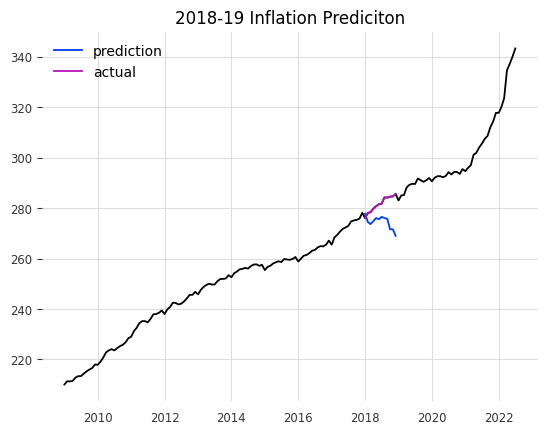

In [45]:
plt.plot(y)
plt.plot(test_results1['test_predictions'], label='prediction')
plt.plot(test_results1['test_actual'], label='actual')
plt.title('2018-19 Inflation Prediciton')
plt.legend()

# LSTM 2019-2020

In [46]:
X_train2, y_train2 = X[:96], y[:96]
X_val2, y_val2 = X[96:120], y[96:120]
X_test2, y_test2 = X[120:132], y[120:132]
X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape

((96, 11), (96,), (24, 11), (24,), (12, 11), (12,))

In [47]:
y_train2_x = expand_dims(y_train2, -1)
y_train2_x = expand_dims(y_train2_x, -1)

y_train2_x.shape

TensorShape([96, 1, 1])

In [48]:
y_val2_x = expand_dims(y_val2, -1)
y_val2_x = expand_dims(y_val2_x, -1)

In [49]:
X_test2_x = expand_dims(X_test2, -2)

In [50]:
X_train2_x = expand_dims(X_train2, -2)
X_train2_x.shape

TensorShape([96, 1, 11])

In [51]:
X_val2_x = expand_dims(X_val2, -2)
X_val2_x.shape

TensorShape([24, 1, 11])

In [52]:
normalizer = Normalization()
normalizer.adapt(X_train2_x)

model3 = Sequential()
model3.add(normalizer)

model3.add(LSTM(units = 100, activation='tanh', return_sequences = True))
model3.add(LSTM(units = 50 , activation='tanh', return_sequences = False))

model3.add(Flatten())

model3.add(Dense(100,activation =  'relu'))
model3.add(Dense(50,activation =  'relu'))
model3.add(Dense(25,activation =  'relu'))

model3.add(Dense(1, activation = 'linear'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, None, 11)         23        
 ion)                                                            
                                                                 
 lstm_4 (LSTM)               (None, None, 100)         44800     
                                                                 
 lstm_5 (LSTM)               (None, 50)                30200     
                                                                 
 flatten_2 (Flatten)         (None, 50)                0         
                                                                 
 dense_8 (Dense)             (None, 100)               5100      
                                                                 
 dense_9 (Dense)             (None, 50)                5050      
                                                      

In [53]:
model3.compile(loss= mape, optimizer= adam, metrics=['mape'])

In [54]:
model3.fit(X_train2_x, y_train2,batch_size = 32, validation_data=(X_val2_x, y_val2), epochs=10000, callbacks = (es))

Epoch 1/10000
3/3 [==============================] - 2s 275ms/step - loss: 99.9877 - mape: 99.9877 - val_loss: 99.9601 - val_mape: 99.9601
Epoch 2/10000
3/3 [==============================] - 0s 24ms/step - loss: 99.9311 - mape: 99.9311 - val_loss: 99.8826 - val_mape: 99.8826
Epoch 3/10000
3/3 [==============================] - 0s 22ms/step - loss: 99.7967 - mape: 99.7967 - val_loss: 99.7107 - val_mape: 99.7107
Epoch 4/10000
3/3 [==============================] - 0s 24ms/step - loss: 99.4976 - mape: 99.4976 - val_loss: 99.3463 - val_mape: 99.3463
Epoch 5/10000
3/3 [==============================] - 0s 24ms/step - loss: 98.8705 - mape: 98.8705 - val_loss: 98.6605 - val_mape: 98.6605
Epoch 6/10000
3/3 [==============================] - 0s 24ms/step - loss: 97.5282 - mape: 97.5282 - val_loss: 97.4449 - val_mape: 97.4449
Epoch 7/10000
3/3 [==============================] - 0s 22ms/step - loss: 94.9331 - mape: 94.9331 - val_loss: 95.5021 - val_mape: 95.5021
Epoch 8/10000
3/3 [==============

3/3 [==============================] - 0s 18ms/step - loss: 1.1519 - mape: 1.1519 - val_loss: 4.3728 - val_mape: 4.3728
Epoch 62/10000
3/3 [==============================] - 0s 19ms/step - loss: 1.0261 - mape: 1.0261 - val_loss: 4.2148 - val_mape: 4.2148
Epoch 63/10000
3/3 [==============================] - 0s 20ms/step - loss: 1.0019 - mape: 1.0019 - val_loss: 4.9095 - val_mape: 4.9095
Epoch 64/10000
3/3 [==============================] - 0s 19ms/step - loss: 0.9796 - mape: 0.9796 - val_loss: 4.2474 - val_mape: 4.2474
Epoch 65/10000
3/3 [==============================] - 0s 19ms/step - loss: 1.0060 - mape: 1.0060 - val_loss: 4.4342 - val_mape: 4.4342
Epoch 66/10000
3/3 [==============================] - 0s 20ms/step - loss: 0.9564 - mape: 0.9564 - val_loss: 4.5320 - val_mape: 4.5320
Epoch 67/10000
3/3 [==============================] - 0s 20ms/step - loss: 0.9176 - mape: 0.9176 - val_loss: 4.2297 - val_mape: 4.2297
Epoch 68/10000
3/3 [==============================] - 0s 21ms/step - l

In [55]:
test_prediction2 = list(model3.predict(X_test2_x))


1/1 [==============================] - 1s 552ms/step


In [56]:
test_results2 = pd.DataFrame(columns = ['test_predictions', 'test_actual'])

#train_predictions

test_results2['date'] = list(y_test2.index)
test_results2['test_predictions'] = [x[0] for x in test_prediction2]
test_results2['test_actual'] = list(y[120:132])

In [57]:
test_results2.set_index('date', inplace=True)

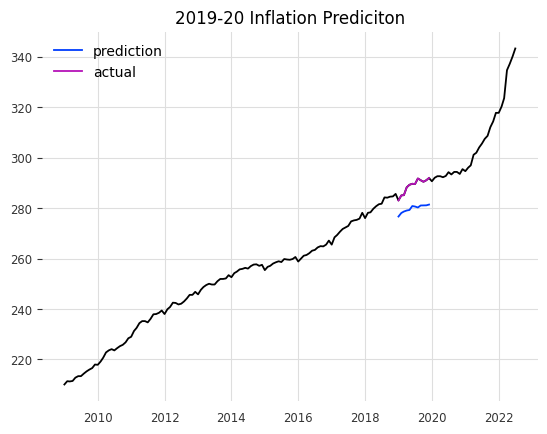

In [58]:
plt.plot(y)
plt.plot(test_results2['test_predictions'], label='prediction')
plt.plot(test_results2['test_actual'], label='actual')
plt.title('2019-20 Inflation Prediciton')
plt.legend()
#plt.savefig('LSTM_2019-20')

# LSTM 2020-2021

In [59]:
X[132:144]

,Brent_Crude_GBP,WTI_Crude_GBP,GBP Curncy,GBPEUR Curncy,UKX Index,SPX Index,SX5E Index,Natural_Gas,GBP_IRS_2y,GBP_IRS_10y,Nationwide_HPI
Date,,,,,,,,,,,
2020-01-01,49.021977,37.434634,1.298861,1.160843,7036.697727,2497.268828,3060.333106,7.781994,0.692330,0.710236,430.7
2020-02-01,42.943990,35.965277,1.291857,1.164014,6796.644286,2501.024605,3019.880708,7.418630,0.683318,0.645300,431.1
2020-03-01,27.211757,25.801736,1.239504,1.111822,5813.382174,2243.053117,2631.283557,6.975790,0.496927,0.614401,438.0
2020-04-01,21.072957,17.991584,1.263773,1.139632,6002.315714,2370.656764,2666.200693,5.995653,0.470125,0.524649,444.7
2020-05-01,25.990237,28.047836,1.247080,1.123495,6134.460000,2450.288506,2722.792714,4.950512,0.327838,0.459777,436.7
2020-06-01,32.338286,31.462164,1.260819,1.118319,6267.593333,2475.319143,2906.093329,5.429804,0.243187,0.453932,431.7
2020-07-01,33.762927,31.986664,1.280167,1.112688,6244.110000,2520.160305,2990.676103,5.291466,0.139427,0.406336,440.7
2020-08-01,34.536521,31.706150,1.303548,1.117148,6163.494211,2569.477068,2952.475053,6.921193,0.104939,0.457958,447.1
2020-09-01,32.488230,30.814480,1.288886,1.106245,6078.599545,2558.413712,2949.601847,8.556717,0.066389,0.432595,451.1


In [60]:
X_train3, y_train3 = X[:108], y[:108]
X_val3, y_val3 = X[108:132], y[108:132]
X_test3, y_test3 = X[132:144], y[132:144]
X_train3.shape, y_train3.shape, X_val3.shape, y_val3.shape, X_test3.shape, y_test3.shape

((108, 11), (108,), (24, 11), (24,), (12, 11), (12,))

In [61]:
y_train3_x = expand_dims(y_train3, -1)
y_train3_x = expand_dims(y_train3_x, -1)

y_train3_x.shape

TensorShape([108, 1, 1])

In [62]:
y_val3_x = expand_dims(y_val3, -1)
y_val3_x = expand_dims(y_val3_x, -1)

In [63]:
X_test3_x = expand_dims(X_test3, -2)

In [64]:
X_train3_x = expand_dims(X_train3, -2)
X_train3_x.shape

TensorShape([108, 1, 11])

In [65]:
X_val3_x = expand_dims(X_val3, -2)
X_val3_x.shape

TensorShape([24, 1, 11])

In [66]:
normalizer = Normalization()
normalizer.adapt(X_train3_x)

model4 = Sequential()
model4.add(normalizer)

model4.add(LSTM(units = 100, activation='tanh', return_sequences = True))
model4.add(LSTM(units = 50 , activation='tanh', return_sequences = False))

model4.add(Flatten())

model4.add(Dense(100,activation =  'relu'))
model4.add(Dense(50,activation =  'relu'))
model4.add(Dense(25,activation =  'relu'))

model4.add(Dense(1, activation = 'linear'))

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, None, 11)         23        
 ion)                                                            
                                                                 
 lstm_6 (LSTM)               (None, None, 100)         44800     
                                                                 
 lstm_7 (LSTM)               (None, 50)                30200     
                                                                 
 flatten_3 (Flatten)         (None, 50)                0         
                                                                 
 dense_12 (Dense)            (None, 100)               5100      
                                                                 
 dense_13 (Dense)            (None, 50)                5050      
                                                      

In [67]:
model4.compile(loss= mape, optimizer= adam, metrics=['mape'])

In [68]:
model4.fit(X_train3_x, y_train3,batch_size = 32, validation_data=(X_val3_x, y_val3), epochs=10000, callbacks = (es))

Epoch 1/10000
4/4 [==============================] - 3s 191ms/step - loss: 99.9911 - mape: 99.9911 - val_loss: 99.9555 - val_mape: 99.9555
Epoch 2/10000
4/4 [==============================] - 0s 19ms/step - loss: 99.9169 - mape: 99.9169 - val_loss: 99.7930 - val_mape: 99.7930
Epoch 3/10000
4/4 [==============================] - 0s 19ms/step - loss: 99.6753 - mape: 99.6753 - val_loss: 99.2301 - val_mape: 99.2301
Epoch 4/10000
4/4 [==============================] - 0s 19ms/step - loss: 98.9255 - mape: 98.9255 - val_loss: 97.6539 - val_mape: 97.6539
Epoch 5/10000
4/4 [==============================] - 0s 19ms/step - loss: 96.8318 - mape: 96.8318 - val_loss: 93.0794 - val_mape: 93.0794
Epoch 6/10000
4/4 [==============================] - 0s 17ms/step - loss: 91.2613 - mape: 91.2613 - val_loss: 83.1084 - val_mape: 83.1084
Epoch 7/10000
4/4 [==============================] - 0s 18ms/step - loss: 79.4405 - mape: 79.4405 - val_loss: 64.1909 - val_mape: 64.1909
Epoch 8/10000
4/4 [==============

4/4 [==============================] - 0s 16ms/step - loss: 0.9647 - mape: 0.9647 - val_loss: 4.1543 - val_mape: 4.1543
Epoch 62/10000
4/4 [==============================] - 0s 17ms/step - loss: 1.2716 - mape: 1.2716 - val_loss: 6.1216 - val_mape: 6.1216
Epoch 63/10000
4/4 [==============================] - 0s 20ms/step - loss: 0.9798 - mape: 0.9798 - val_loss: 4.8872 - val_mape: 4.8872


In [69]:
test_prediction3 = list(model4.predict(X_test3_x))


1/1 [==============================] - 1s 524ms/step


In [70]:
test_results3 = pd.DataFrame(columns = ['test_predictions', 'test_actual'])

#train_predictions

test_results3['date'] = list(y_test3.index)
test_results3['test_predictions'] = [x[0] for x in test_prediction3]
test_results3['test_actual'] = list(y_test3)

In [71]:
test_results3.set_index('date', inplace=True)

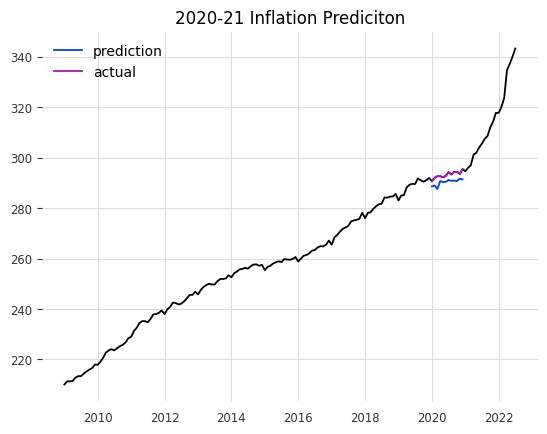

In [72]:
plt.plot(y)
plt.plot(test_results3['test_predictions'], label='prediction')
plt.plot(test_results3['test_actual'], label='actual')
plt.title('2020-21 Inflation Prediciton')
plt.legend()
plt.savefig('LSTM_2020-21')

# LSTM 2021-2022

In [73]:
X[:165]

,Brent_Crude_GBP,WTI_Crude_GBP,GBP Curncy,GBPEUR Curncy,UKX Index,SPX Index,SX5E Index,Natural_Gas,GBP_IRS_2y,GBP_IRS_10y,Nationwide_HPI
Date,,,,,,,,,,,
2009-01-01,30.903838,33.424333,1.479027,1.099905,4308.390000,596.071497,2135.982324,12.472805,2.122545,3.757500,300.2
2009-02-01,29.393166,33.617553,1.492643,1.120824,4232.114762,570.410394,2020.716905,9.467866,2.129905,3.798333,294.7
2009-03-01,31.733352,36.826152,1.494241,1.097877,4107.840909,566.393975,2029.160819,8.064295,2.142045,3.872500,301.1
2009-04-01,33.990786,36.012519,1.511936,1.125327,4259.890500,588.042125,2119.383029,7.762397,2.143250,3.935500,302.9
2009-05-01,37.524515,38.801542,1.561252,1.131686,4434.719500,582.718727,2164.120107,7.757394,2.031900,3.917500,307.2
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-01,89.748267,85.128666,1.247484,1.178074,7472.767778,3274.256696,3179.554466,81.073170,2.538121,2.240542,538.4
2022-06-01,95.251442,87.836565,1.233611,1.167758,7238.188421,3172.340166,3058.969505,96.746393,2.933563,2.626558,541.8
2022-07-01,85.363871,80.415504,1.231479,1.184589,7303.865263,3298.689210,3082.959231,128.688654,2.700779,2.302258,541.0


In [74]:
X_train4, y_train4 = X[:132], y[:132]
X_val4, y_val4 = X[132:156], y[132:156]
X_test4, y_test4 = X[156:165], y[156:165]
X_train4.shape, y_train4.shape, X_val4.shape, y_val4.shape, X_test4.shape, y_test4.shape

((132, 11), (132,), (24, 11), (24,), (9, 11), (9,))

In [75]:
y_train4_x = expand_dims(y_train4, -1)
y_train4_x = expand_dims(y_train4_x, -1)

y_train4_x.shape

TensorShape([132, 1, 1])

In [76]:
y_val4_x = expand_dims(y_val4, -1)
y_val4_x = expand_dims(y_val4_x, -1)

In [77]:
X_test4_x = expand_dims(X_test4, -2)

In [78]:
X_train4_x = expand_dims(X_train4, -2)
X_train4_x.shape

TensorShape([132, 1, 11])

In [79]:
X_val4_x = expand_dims(X_val4, -2)
X_val4_x.shape

TensorShape([24, 1, 11])

In [80]:
normalizer = Normalization()
normalizer.adapt(X_train4_x)

model5 = Sequential()
model5.add(normalizer)

model5.add(LSTM(units = 100, activation='tanh', return_sequences = True))
model5.add(LSTM(units = 50 , activation='tanh', return_sequences = False))

model5.add(Flatten())

model5.add(Dense(100,activation =  'relu'))
model5.add(Dense(50,activation =  'relu'))
model5.add(Dense(25,activation =  'relu'))

model5.add(Dense(1, activation = 'linear'))

model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, None, 11)         23        
 ion)                                                            
                                                                 
 lstm_8 (LSTM)               (None, None, 100)         44800     
                                                                 
 lstm_9 (LSTM)               (None, 50)                30200     
                                                                 
 flatten_4 (Flatten)         (None, 50)                0         
                                                                 
 dense_16 (Dense)            (None, 100)               5100      
                                                                 
 dense_17 (Dense)            (None, 50)                5050      
                                                      

In [81]:
model5.compile(loss= mape, optimizer= adam, metrics=['mape'])

In [82]:
model5.fit(X_train4_x, y_train4,batch_size = 32, validation_data=(X_val4_x, y_val4), epochs=10000, callbacks = (es))

Epoch 1/10000
5/5 [==============================] - 3s 140ms/step - loss: 99.9895 - mape: 99.9895 - val_loss: 99.9387 - val_mape: 99.9387
Epoch 2/10000
5/5 [==============================] - 0s 16ms/step - loss: 99.8768 - mape: 99.8768 - val_loss: 99.5727 - val_mape: 99.5727
Epoch 3/10000
5/5 [==============================] - 0s 16ms/step - loss: 99.3603 - mape: 99.3603 - val_loss: 97.5620 - val_mape: 97.5620
Epoch 4/10000
5/5 [==============================] - 0s 16ms/step - loss: 96.9548 - mape: 96.9548 - val_loss: 90.5896 - val_mape: 90.5896
Epoch 5/10000
5/5 [==============================] - 0s 16ms/step - loss: 89.0830 - mape: 89.0830 - val_loss: 74.3175 - val_mape: 74.3175
Epoch 6/10000
5/5 [==============================] - 0s 15ms/step - loss: 69.3220 - mape: 69.3220 - val_loss: 43.9337 - val_mape: 43.9337
Epoch 7/10000
5/5 [==============================] - 0s 15ms/step - loss: 30.1910 - mape: 30.1910 - val_loss: 8.3321 - val_mape: 8.3321
Epoch 8/10000
5/5 [================

5/5 [==============================] - 0s 14ms/step - loss: 1.5101 - mape: 1.5101 - val_loss: 5.8551 - val_mape: 5.8551
Epoch 62/10000
5/5 [==============================] - 0s 14ms/step - loss: 1.8589 - mape: 1.8589 - val_loss: 3.8533 - val_mape: 3.8533
Epoch 63/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.2551 - mape: 1.2551 - val_loss: 3.4644 - val_mape: 3.4644
Epoch 64/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.0451 - mape: 1.0451 - val_loss: 4.8593 - val_mape: 4.8593
Epoch 65/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.1344 - mape: 1.1344 - val_loss: 4.2021 - val_mape: 4.2021
Epoch 66/10000
5/5 [==============================] - 0s 16ms/step - loss: 1.1372 - mape: 1.1372 - val_loss: 3.2135 - val_mape: 3.2135
Epoch 67/10000
5/5 [==============================] - 0s 16ms/step - loss: 1.1756 - mape: 1.1756 - val_loss: 4.5417 - val_mape: 4.5417
Epoch 68/10000
5/5 [==============================] - 0s 14ms/step - l

In [83]:
test_prediction4 = list(model5.predict(X_test4_x))
test_prediction4


2022-09-13 09:43:44 tensorflow WARNING: 5 out of the last 6 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f109669fc10> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 488ms/step


[array([304.3622], dtype=float32),
 array([299.63562], dtype=float32),
 array([270.91266], dtype=float32),
 array([270.92456], dtype=float32),
 array([256.7617], dtype=float32),
 array([286.75885], dtype=float32),
 array([268.9507], dtype=float32),
 array([281.41074], dtype=float32),
 array([2.987187], dtype=float32)]

In [84]:
test_results4 = pd.DataFrame(columns = ['test_predictions', 'test_actual'])

#train_predictions

test_results4['date'] = list(y_test4.index)
test_results4['test_predictions'] = [x[0] for x in test_prediction4]
test_results4['test_actual'] = list(y_test4)

In [85]:
test_results4.set_index('date', inplace=True)

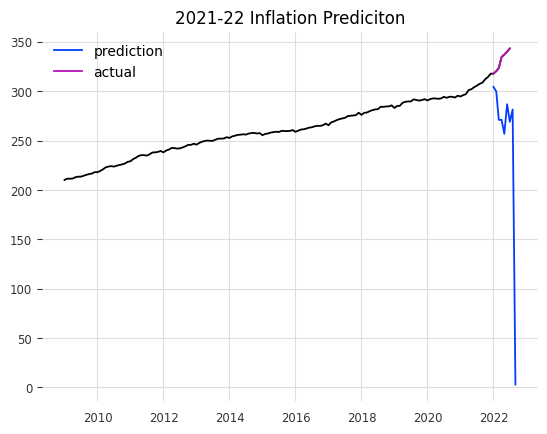

In [86]:
plt.plot(y)
plt.plot(test_results4['test_predictions'], label='prediction')
plt.plot(test_results4['test_actual'], label='actual')
plt.title('2021-22 Inflation Prediciton')
plt.legend()

# LSTM 2022-

In [87]:
X[159:165]

,Brent_Crude_GBP,WTI_Crude_GBP,GBP Curncy,GBPEUR Curncy,UKX Index,SPX Index,SX5E Index,Natural_Gas,GBP_IRS_2y,GBP_IRS_10y,Nationwide_HPI
Date,,,,,,,,,,,
2022-04-01,82.294714,78.884404,1.287045,1.194540,7475.842222,3390.642475,3202.490777,86.613133,2.365979,2.085100,533.9
2022-05-01,89.748267,85.128666,1.247484,1.178074,7472.767778,3274.256696,3179.554466,81.073170,2.538121,2.240542,538.4
2022-06-01,95.251442,87.836565,1.233611,1.167758,7238.188421,3172.340166,3058.969505,96.746393,2.933563,2.626558,541.8
2022-07-01,85.363871,80.415504,1.231479,1.184589,7303.865263,3298.689210,3082.959231,128.688654,2.700779,2.302258,541.0
2022-08-01,80.656541,78.913331,1.211816,1.181732,7453.987222,3446.779300,3131.457852,180.082147,3.368889,2.688500,546.1
2022-09-01,73.474167,80.706056,1.272420,1.180400,7403.016000,3300.260920,3208.537784,93.341821,2.475340,2.155940,NaN


In [195]:
X_train5, y_train5 = X[:156], y[:156]
X_val5, y_val5 = X[156:163], y[156:163]
X_test5, y_test5 = X[163:164], y[163:164]
X_train5.shape, y_train5.shape, X_val5.shape, y_val5.shape, X_test5.shape, y_test5.shape

((156, 11), (156,), (7, 11), (7,), (1, 11), (1,))

In [196]:
y_train5_x = expand_dims(y_train5, -1)
y_train5_x = expand_dims(y_train5_x, -1)

y_train5_x.shape

TensorShape([156, 1, 1])

In [197]:
y_val5_x = expand_dims(y_val5, -1)
y_val5_x = expand_dims(y_val5_x, -1)

In [198]:
X_test5_x = expand_dims(X_test5, -2)

In [199]:
X_train5_x = expand_dims(X_train5, -2)
X_train5_x.shape

TensorShape([156, 1, 11])

In [200]:
X_val5_x = expand_dims(X_val5, -2)
X_val5_x.shape

TensorShape([7, 1, 11])

In [341]:
normalizer = Normalization()
normalizer.adapt(X_train5_x)

model6 = Sequential()
model6.add(normalizer)

model6.add(LSTM(units = 110, activation='tanh', return_sequences = True))
model6.add(LSTM(units = 50 , activation='tanh', return_sequences = False))

model6.add(Flatten())

model6.add(Dense(100,activation =  'relu'))
model6.add(Dense(50,activation =  'relu'))
model6.add(Dense(25,activation =  'relu'))
model6.add(Dense(25,activation =  'relu'))
model6.add(Dense(12,activation =  'relu'))




model6.add(Dense(1, activation = 'linear'))

model6.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_35 (Normaliza  (None, None, 11)         23        
 tion)                                                           
                                                                 
 lstm_70 (LSTM)              (None, None, 110)         53680     
                                                                 
 lstm_71 (LSTM)              (None, 50)                32200     
                                                                 
 flatten_35 (Flatten)        (None, 50)                0         
                                                                 
 dense_198 (Dense)           (None, 100)               5100      
                                                                 
 dense_199 (Dense)           (None, 50)                5050      
                                                     

In [342]:
model6.compile(loss= mape, optimizer= adam, metrics=['mape'])

In [343]:
model6.fit(X_train5_x, y_train5, batch_size = 16, validation_data=(X_val5_x, y_val5), epochs=10000, callbacks = (es))

Epoch 1/10000
10/10 [==============================] - 3s 66ms/step - loss: 99.9339 - mape: 99.9339 - val_loss: 99.7994 - val_mape: 99.7994
Epoch 2/10000
10/10 [==============================] - 0s 9ms/step - loss: 99.0067 - mape: 99.0067 - val_loss: 98.0896 - val_mape: 98.0896
Epoch 3/10000
10/10 [==============================] - 0s 8ms/step - loss: 89.5427 - mape: 89.5427 - val_loss: 86.6085 - val_mape: 86.6085
Epoch 4/10000
10/10 [==============================] - 0s 8ms/step - loss: 51.3112 - mape: 51.3112 - val_loss: 44.2508 - val_mape: 44.2508
Epoch 5/10000
10/10 [==============================] - 0s 8ms/step - loss: 21.7156 - mape: 21.7156 - val_loss: 10.2488 - val_mape: 10.2488
Epoch 6/10000
10/10 [==============================] - 0s 8ms/step - loss: 14.5704 - mape: 14.5704 - val_loss: 37.5319 - val_mape: 37.5319
Epoch 7/10000
10/10 [==============================] - 0s 8ms/step - loss: 10.0308 - mape: 10.0308 - val_loss: 44.1947 - val_mape: 44.1947
Epoch 8/10000
10/10 [=====

10/10 [==============================] - 0s 7ms/step - loss: 1.2398 - mape: 1.2398 - val_loss: 8.3862 - val_mape: 8.3862
Epoch 61/10000
10/10 [==============================] - 0s 7ms/step - loss: 1.3450 - mape: 1.3450 - val_loss: 8.0148 - val_mape: 8.0148
Epoch 62/10000
10/10 [==============================] - 0s 7ms/step - loss: 1.5065 - mape: 1.5065 - val_loss: 8.1718 - val_mape: 8.1718
Epoch 63/10000
10/10 [==============================] - 0s 7ms/step - loss: 1.5221 - mape: 1.5221 - val_loss: 8.1239 - val_mape: 8.1239
Epoch 64/10000
10/10 [==============================] - 0s 7ms/step - loss: 1.3906 - mape: 1.3906 - val_loss: 7.6098 - val_mape: 7.6098
Epoch 65/10000
10/10 [==============================] - 0s 7ms/step - loss: 1.3133 - mape: 1.3133 - val_loss: 7.3937 - val_mape: 7.3937
Epoch 66/10000
10/10 [==============================] - 0s 8ms/step - loss: 1.2358 - mape: 1.2358 - val_loss: 7.1775 - val_mape: 7.1775
Epoch 67/10000
10/10 [==============================] - 0s 7ms/

10/10 [==============================] - 0s 7ms/step - loss: 0.9300 - mape: 0.9300 - val_loss: 4.8338 - val_mape: 4.8338
Epoch 121/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.9996 - mape: 0.9996 - val_loss: 5.1482 - val_mape: 5.1482
Epoch 122/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.8965 - mape: 0.8965 - val_loss: 4.9557 - val_mape: 4.9557
Epoch 123/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.9256 - mape: 0.9256 - val_loss: 4.8176 - val_mape: 4.8176
Epoch 124/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.9348 - mape: 0.9348 - val_loss: 4.8292 - val_mape: 4.8292
Epoch 125/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.8719 - mape: 0.8719 - val_loss: 4.7914 - val_mape: 4.7914
Epoch 126/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.8105 - mape: 0.8105 - val_loss: 4.8989 - val_mape: 4.8989
Epoch 127/10000
10/10 [==============================] - 

Epoch 180/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.6129 - mape: 0.6129 - val_loss: 4.3290 - val_mape: 4.3290
Epoch 181/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.6451 - mape: 0.6451 - val_loss: 4.4614 - val_mape: 4.4614
Epoch 182/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.6867 - mape: 0.6867 - val_loss: 4.5442 - val_mape: 4.5442
Epoch 183/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.6755 - mape: 0.6755 - val_loss: 4.4231 - val_mape: 4.4231
Epoch 184/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.6522 - mape: 0.6522 - val_loss: 4.2643 - val_mape: 4.2643
Epoch 185/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.5932 - mape: 0.5932 - val_loss: 4.3213 - val_mape: 4.3213
Epoch 186/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.5801 - mape: 0.5801 - val_loss: 4.4255 - val_mape: 4.4255
Epoch 187/10000
10/10 [==================

Epoch 240/10000
10/10 [==============================] - 0s 8ms/step - loss: 0.5422 - mape: 0.5422 - val_loss: 3.5072 - val_mape: 3.5072
Epoch 241/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.6317 - mape: 0.6317 - val_loss: 3.4748 - val_mape: 3.4748
Epoch 242/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.6042 - mape: 0.6042 - val_loss: 3.5753 - val_mape: 3.5753
Epoch 243/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.6196 - mape: 0.6196 - val_loss: 3.6051 - val_mape: 3.6051
Epoch 244/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.7584 - mape: 0.7584 - val_loss: 3.4626 - val_mape: 3.4626
Epoch 245/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.6445 - mape: 0.6445 - val_loss: 3.5347 - val_mape: 3.5347
Epoch 246/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.6596 - mape: 0.6596 - val_loss: 3.4523 - val_mape: 3.4523
Epoch 247/10000
10/10 [==================

Epoch 300/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.4543 - mape: 0.4543 - val_loss: 3.3760 - val_mape: 3.3760
Epoch 301/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.4740 - mape: 0.4740 - val_loss: 3.1659 - val_mape: 3.1659
Epoch 302/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.4536 - mape: 0.4536 - val_loss: 3.1651 - val_mape: 3.1651
Epoch 303/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.4579 - mape: 0.4579 - val_loss: 3.3001 - val_mape: 3.3001
Epoch 304/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.4286 - mape: 0.4286 - val_loss: 3.2530 - val_mape: 3.2530
Epoch 305/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.4156 - mape: 0.4156 - val_loss: 3.2511 - val_mape: 3.2511
Epoch 306/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.4031 - mape: 0.4031 - val_loss: 3.1933 - val_mape: 3.1933
Epoch 307/10000
10/10 [==================

Epoch 360/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.4027 - mape: 0.4027 - val_loss: 2.9782 - val_mape: 2.9782
Epoch 361/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.4109 - mape: 0.4109 - val_loss: 3.0900 - val_mape: 3.0900
Epoch 362/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.4647 - mape: 0.4647 - val_loss: 2.9705 - val_mape: 2.9705
Epoch 363/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.4125 - mape: 0.4125 - val_loss: 3.0695 - val_mape: 3.0695
Epoch 364/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.5340 - mape: 0.5340 - val_loss: 3.0361 - val_mape: 3.0361
Epoch 365/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.5265 - mape: 0.5265 - val_loss: 3.0355 - val_mape: 3.0355
Epoch 366/10000
10/10 [==============================] - 0s 7ms/step - loss: 0.4067 - mape: 0.4067 - val_loss: 3.0581 - val_mape: 3.0581
Epoch 367/10000
10/10 [==================

In [344]:
test_prediction5 = list(model6.predict(X_test5_x))


1/1 [==============================] - 0s 491ms/step


In [345]:
test_prediction5

[array([334.41638], dtype=float32)]

In [275]:
y_test5

Date
2022-08-01   NaN
Name: RPI, dtype: float64

In [276]:
# res = []
# for x in range(1):
#     val = pd.to_datetime(pd.DataFrame(y).iloc[-x,:0]).name
#     res.append(val)

In [277]:
# res = res[1:]

In [278]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

In [279]:
# list(y_test5[:-1])

In [280]:
# future_vals = []
# for x in res:
#     future_date = x + relativedelta(months=1)
#     future_vals.append(future_date)

In [281]:
# future_vals

In [282]:
test_results5 = pd.DataFrame(columns = ['test_predictions', 'test_actual'])

#train_predictions

test_results5['date'] = y_test5.index
test_results5['test_predictions'] = [x[0] for x in test_prediction5]
print(test_results5['date'])

0   2022-08-01
Name: date, dtype: datetime64[ns]


In [283]:
test_results5.set_index('date', inplace=True)

In [284]:
print(test_results5)

            test_predictions test_actual
date                                    
2022-08-01         334.95285         NaN


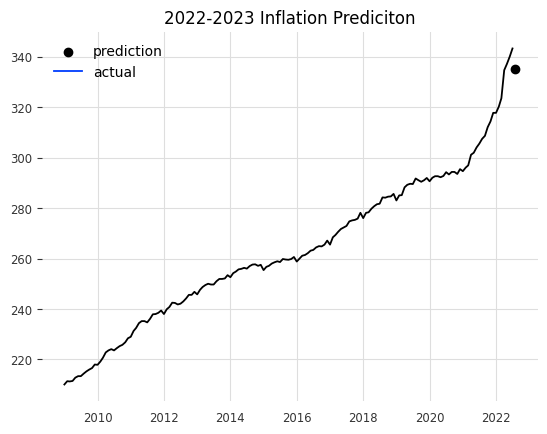

In [285]:
plt.plot(y)
plt.scatter([y_test5.index], test_results5['test_predictions'], label='prediction')
#plt.plot(test_results5['test_predictions'], label='prediction')
plt.plot(test_results5['test_actual'], label='actual')
plt.title('2022-2023 Inflation Prediciton')
plt.legend()
plt.savefig('LSTM_Pred_5th_run')